In [1]:
### Imports (TODO remove this when finished)
%load_ext autoreload
%autoreload 2

# Append root folder in case you haven't installed NIDN
import sys
sys.path.append("../..")

import nidn

18:25:45|NIDN-INFO| Initialized NIDN for cpu
18:25:45|NIDN-INFO| Using double precision


# Single layer , uniform, regression

Physical wavelengths are (in meters):
[9.00000000e-07 8.14285714e-07 7.43478261e-07 6.84000000e-07
 6.33333333e-07 5.89655172e-07 5.51612903e-07 5.18181818e-07
 4.88571429e-07 4.62162162e-07 4.38461538e-07 4.17073171e-07
 3.97674419e-07 3.80000000e-07 3.63829787e-07 3.48979592e-07
 3.35294118e-07 3.22641509e-07 3.10909091e-07 3.00000000e-07]


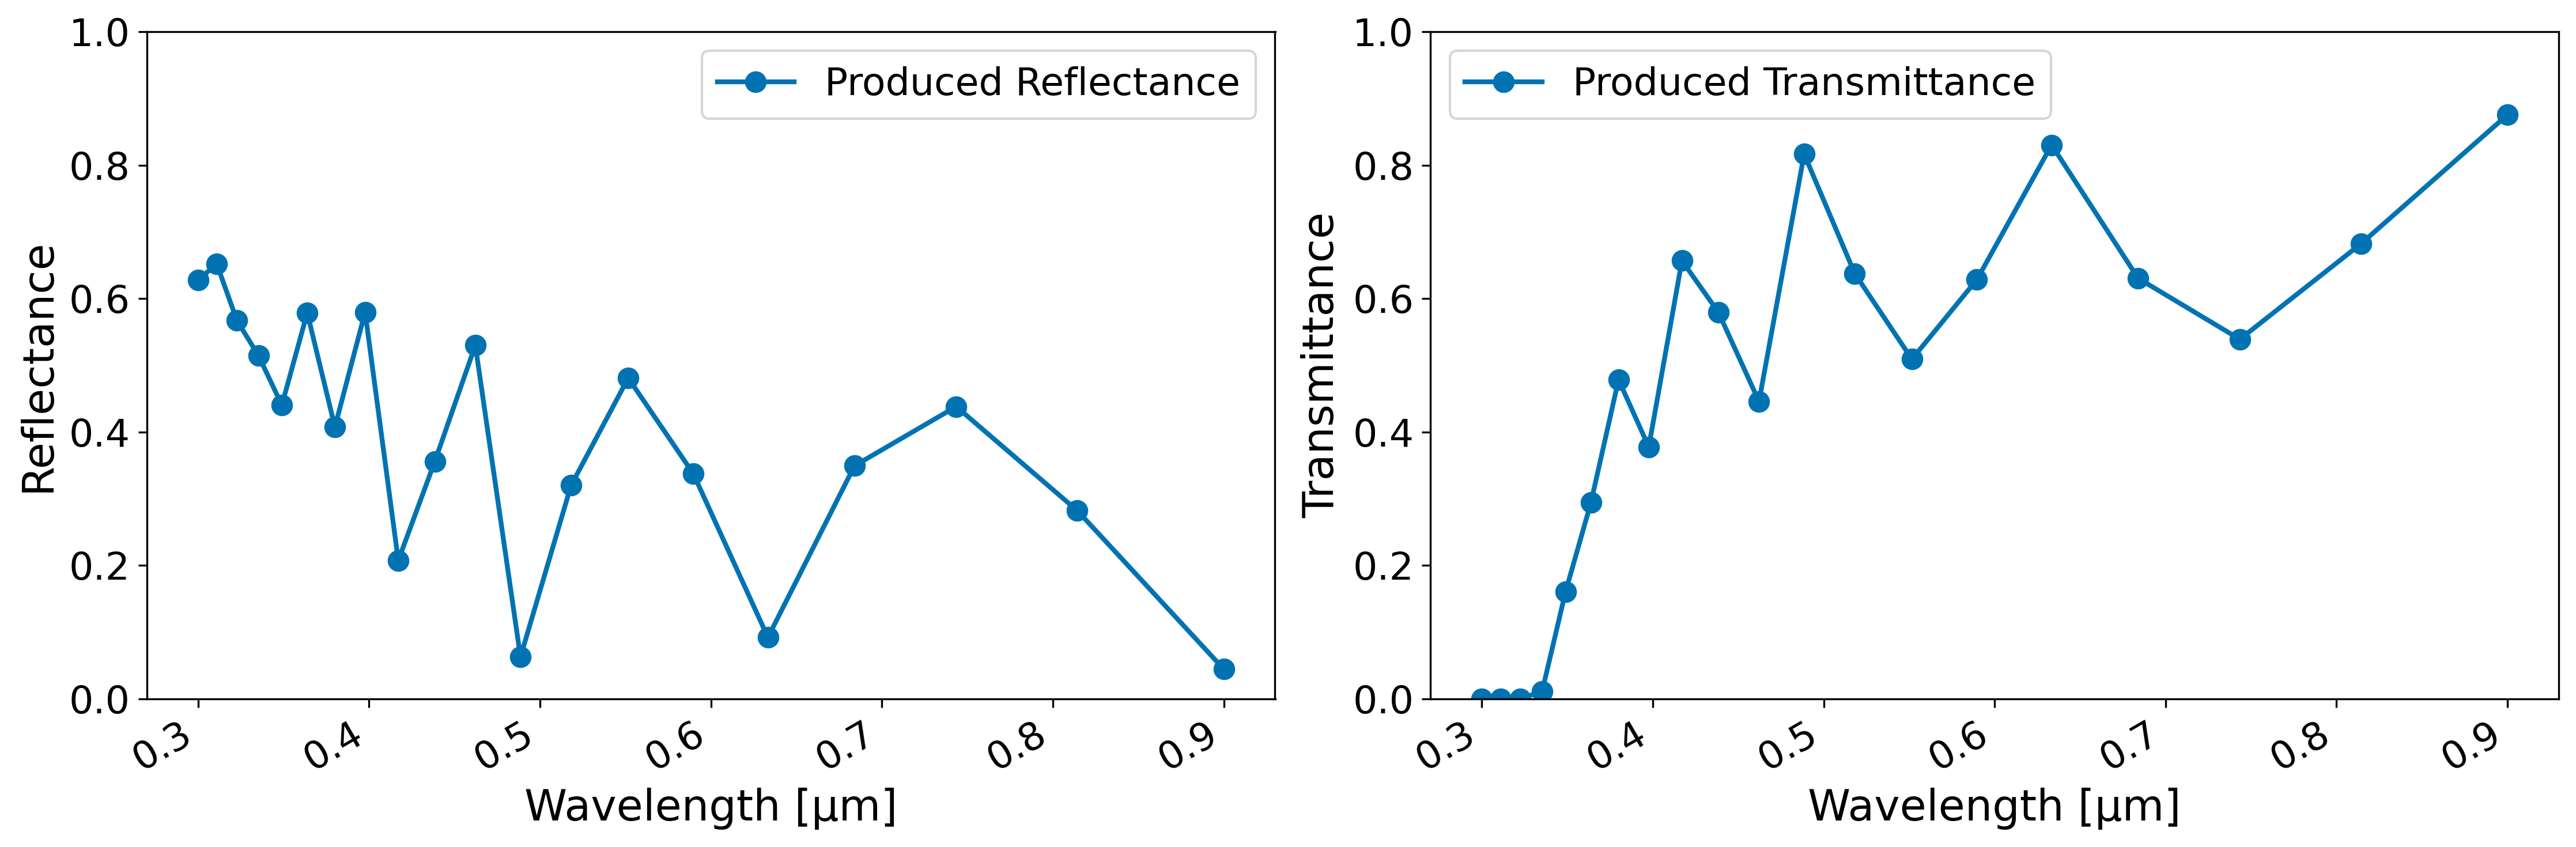

In [2]:
# Load default cfg as starting point
cfg = nidn.load_default_cfg()

# Specify your desired range of wavelengths
cfg.physical_wavelength_range[0] = 3e-7
cfg.physical_wavelength_range[1] = 9e-7
cfg.PER_LAYER_THICKNESS = [0.38]

# Let's investigate 50 frequency points
cfg.N_freq = 20
cfg.solver = "FDTD"
cfg.FDTD_niter = 400
cfg.FDTD_min_gridpoints_per_unit_magnitude = 20 # ground truth was computed for this for speedup
cfg.N_layers = 1
cfg.FDTD_pulse_type = 'continuous'
cfg.FDTD_source_type = 'line'

# Currently, the target spectra is set manually as a list of numbers. Choose each 5th value to reduce from 100 frequency points to 20 frequency points
cfg.target_reflectance_spectrum = [0.04456351,0.07616634,0.12983103,0.20348341,0.20803709,0.28212550,0.34838794,0.35148116,0.40294107,0.43659179,0.43804083,0.45265764,0.42395525,0.42250250,0.35184451,0.34927237,0.23594347,0.22968049,0.10109031,0.09566545,0.09204569,0.04801336,0.04943829,0.15785883,0.16480385,0.33755576,0.34852490,0.35598405,0.47175452,0.47543828,0.48079059,0.47670861,0.47495085,0.47283219,0.33080953,0.31996884,0.30833286,0.29704388,0.07221731,0.06803254,0.06279853,0.25093825,0.27168874,0.29327866,0.31555886,0.52987157,0.53266849,0.53949557,0.54329768,0.54590920,0.35588414,0.34058632,0.30762652,0.27317067,0.16839377,0.20723618,0.25279078,0.27902083,0.33203165,0.38699248,0.57960660,0.56132624,0.54713063,0.50812035,0.47987271,0.40737469,0.31942957,0.41918578,0.46946234,0.55008628,0.57858655,0.60237008,0.22992761,0.32204145,0.38371327,0.44023784,0.49577304,0.49328186,0.46340183,0.45237985,0.51436802,0.52561688,0.53433126,0.54193417,0.55985565,0.56738637,0.57371749,0.57877213,0.65791848,0.65526587,0.65189846,0.64806130,0.64002900,0.63579534,0.63167151,0.62771639,0.62199316,0.66017008,0.65453985,0.64911847,][0::5]
cfg.target_transmittance_spectrum = [0.87536937,0.86225903,0.81306321,0.75287122,0.74871316,0.68198832,0.62422039,0.62128133,0.57431380,0.54036076,0.53893761,0.53746136,0.56318135,0.56430514,0.62822533,0.63025375,0.72190201,0.72902601,0.82516558,0.82823149,0.83023419,0.85988161,0.85803865,0.77452468,0.76844363,0.62843653,0.61871883,0.61209847,0.51762058,0.51417495,0.50911674,0.50285459,0.50413010,0.50572154,0.62959830,0.63739662,0.64559040,0.65416174,0.81584808,0.81671772,0.81649914,0.67631454,0.65980186,0.64488775,0.62678816,0.44563180,0.44270788,0.43865578,0.43446768,0.43148086,0.57915950,0.58924005,0.61020821,0.63242840,0.68207222,0.65677377,0.62419689,0.60660547,0.57197304,0.53173307,0.37738633,0.39192256,0.40217924,0.42987445,0.44531120,0.47829903,0.49511773,0.42511123,0.39097864,0.32282715,0.29403716,0.25334013,0.33381818,0.24619652,0.20109781,0.16036236,0.10121669,0.07910624,0.04449772,0.03074843,0.01117523,0.00339080,0.00167748,0.00077300,0.00015712,0.00006627,0.00003636,0.00001924,0.00000530,0.00000348,0.00000238,0.00000169,0.00000096,0.00000075,0.00000060,0.00000048,0.00000034,0.00000030,0.00000024,0.00000019,][0::5]

nidn.plot_spectrum(cfg,
                   cfg.target_reflectance_spectrum,
                   cfg.target_transmittance_spectrum)

physical_wls, normalized_freqs = nidn.get_frequency_points(cfg)
print("Physical wavelengths are (in meters):")
print(physical_wls)

In [3]:
cfg.pop("model",None); # Forget the old model

# Allowed range of epsilon values
cfg.real_min_eps = 0.00
cfg.real_max_eps = 20.0
cfg.imag_min_eps = 0.0
cfg.imag_max_eps = 6.0

cfg.type = "regression" # Choose type as described above

In [4]:
nidn.print_cfg(cfg)

name                   : example_name   |use_gpu                : 0              |seed                   : 100            |
model_type             : siren          |iterations             : 3000           |learning_rate          : 8e-05          |
type                   : regression     |reg_loss_weight        : 0.05           |use_regularization_loss: 1              |
L                      : 1.0            |absorption_loss        : 0              |n_neurons              : 100            |
hidden_layers          : 9              |encoding_dim           : 4              |siren_omega            : 1.0            |
add_noise              : 0              |noise_scale            : 0.001          |eps_oversampling       : 1              |
real_min_eps           : 0.0            |real_max_eps           : 20.0           |imag_min_eps           : 0.0            |
imag_max_eps           : 6.0            |solver                 : FDTD           |Nx                     : 1              |
Ny      

In [5]:
cfg.iterations = 150 # Set number of training iterations (that is forward model evaluations) to perform
nidn.run_training(cfg);

18:25:50|NIDN-WARNING| Due to the grid resolution, the thickness of layer 1 is set to 0.390 µminstead of the specified 0.38 µm
18:26:43|NIDN-INFO| ###  New Best=0.2953 with SpectrumLoss=0.2953 ### L1=0.2953
18:26:43|NIDN-INFO| It=0     Loss=0.2953   |  weighted_avg=0.2953  |  SpectrumLoss=0.2953 | L1=0.2953
18:28:25|NIDN-INFO| ###  New Best=0.2930 with SpectrumLoss=0.2930 ### L1=0.2930
18:30:07|NIDN-INFO| ###  New Best=0.2840 with SpectrumLoss=0.2840 ### L1=0.2840
18:31:59|NIDN-INFO| ###  New Best=0.2836 with SpectrumLoss=0.2836 ### L1=0.2836
18:33:46|NIDN-INFO| ###  New Best=0.2733 with SpectrumLoss=0.2733 ### L1=0.2733
18:35:31|NIDN-INFO| ###  New Best=0.2672 with SpectrumLoss=0.2672 ### L1=0.2672
18:35:31|NIDN-INFO| It=5     Loss=0.2672   |  weighted_avg=0.2827  |  SpectrumLoss=0.2672 | L1=0.2672
18:37:16|NIDN-INFO| ###  New Best=0.2584 with SpectrumLoss=0.2584 ### L1=0.2584
18:39:05|NIDN-INFO| ###  New Best=0.2550 with SpectrumLoss=0.2550 ### L1=0.2550
18:40:52|NIDN-INFO| ###  New 

21:28:02|NIDN-INFO| ###  New Best=0.0854 with SpectrumLoss=0.0854 ### L1=0.0854
21:30:25|NIDN-INFO| ###  New Best=0.0845 with SpectrumLoss=0.0845 ### L1=0.0845
21:32:32|NIDN-INFO| ###  New Best=0.0795 with SpectrumLoss=0.0795 ### L1=0.0795
21:32:32|NIDN-INFO| It=90    Loss=0.0795   |  weighted_avg=0.1010  |  SpectrumLoss=0.0795 | L1=0.0795
21:39:23|NIDN-INFO| ###  New Best=0.0758 with SpectrumLoss=0.0758 ### L1=0.0758
21:43:33|NIDN-INFO| It=95    Loss=0.0762   |  weighted_avg=0.0918  |  SpectrumLoss=0.0762 | L1=0.0762
21:48:43|NIDN-INFO| ###  New Best=0.0745 with SpectrumLoss=0.0745 ### L1=0.0745
21:52:43|NIDN-INFO| ###  New Best=0.0726 with SpectrumLoss=0.0726 ### L1=0.0726
21:52:43|NIDN-INFO| It=100   Loss=0.0726   |  weighted_avg=0.0838  |  SpectrumLoss=0.0726 | L1=0.0726
22:02:10|NIDN-INFO| It=105   Loss=0.0763   |  weighted_avg=0.0796  |  SpectrumLoss=0.0763 | L1=0.0763
22:10:47|NIDN-INFO| It=110   Loss=0.0745   |  weighted_avg=0.0776  |  SpectrumLoss=0.0745 | L1=0.0745
22:19:25|N

23:30:16|NIDN-WARNING| Due to the grid resolution, the thickness of layer 1 is set to 0.390 µminstead of the specified 0.38 µm


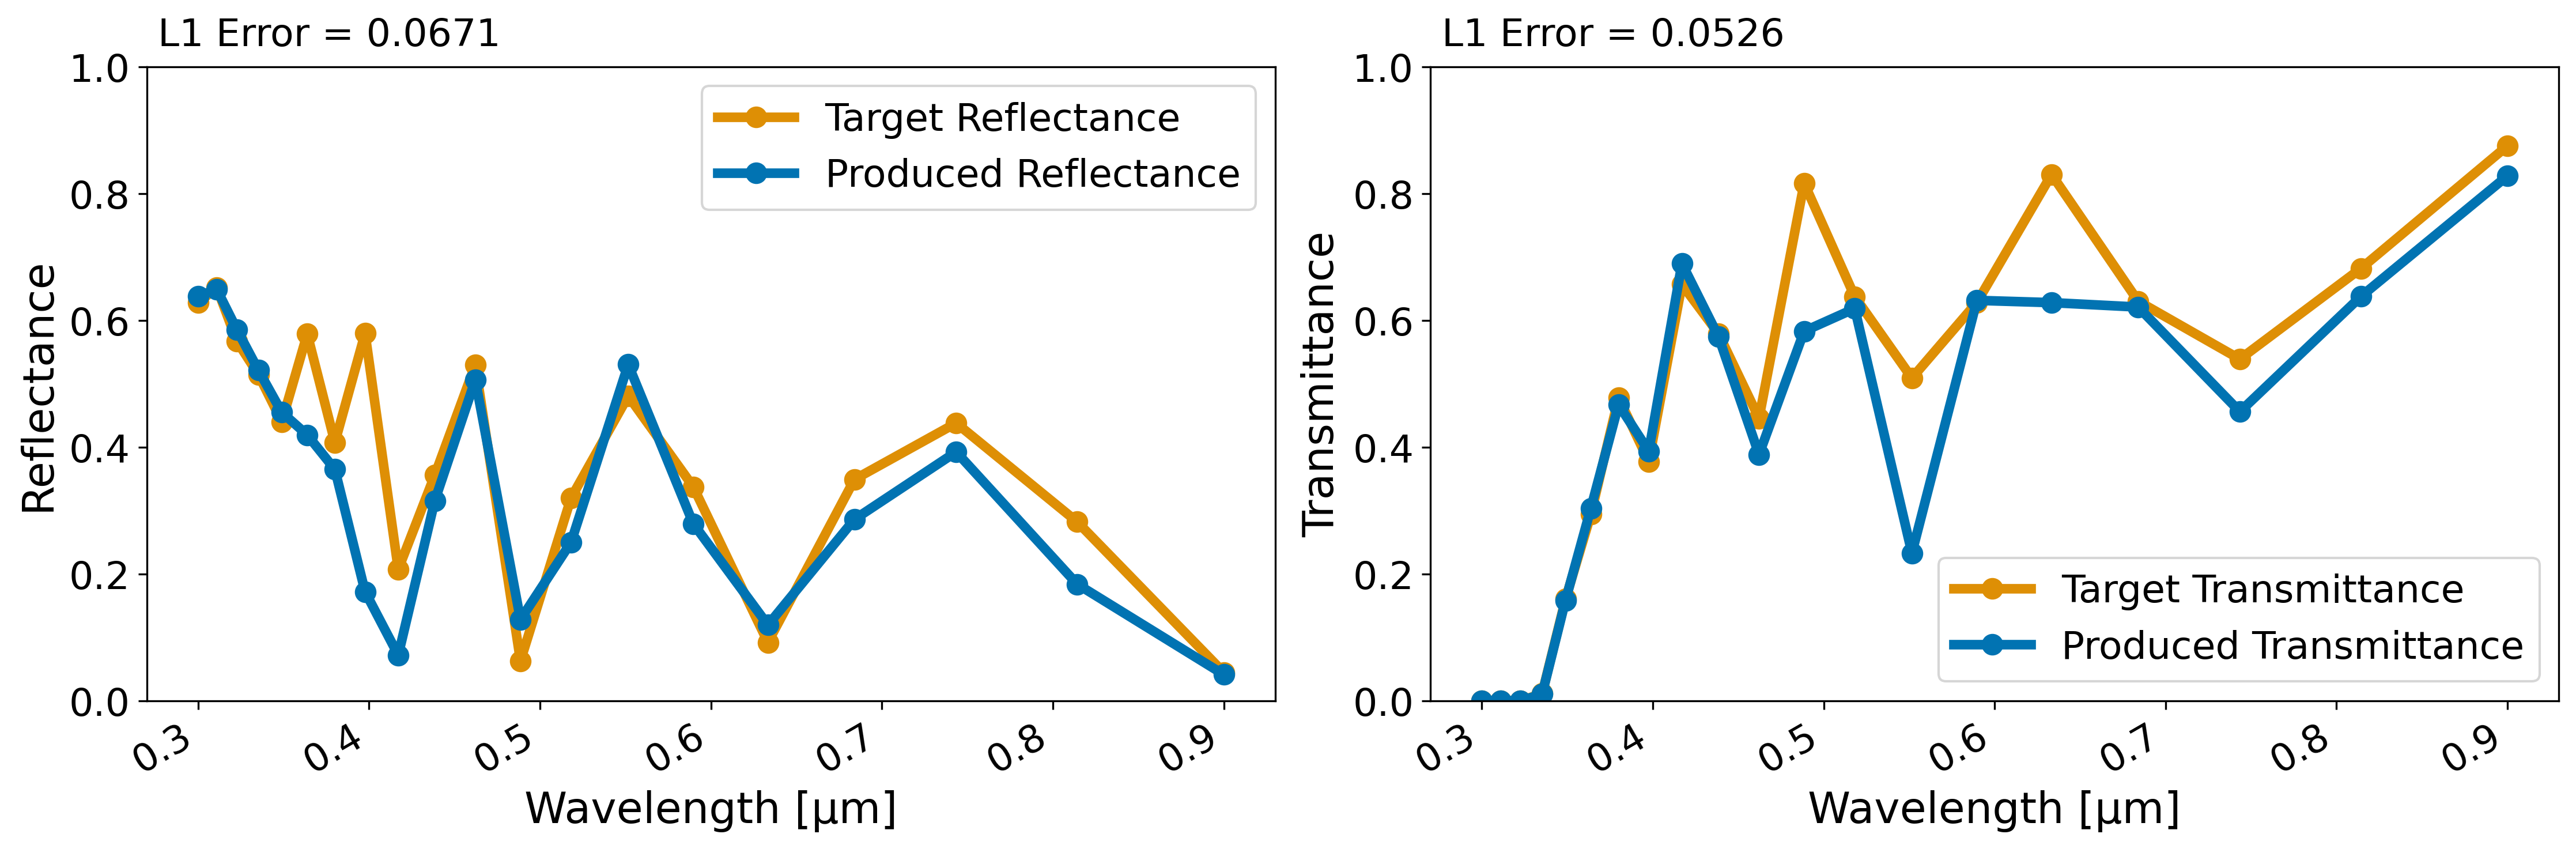

In [6]:
nidn.plot_spectra(cfg)

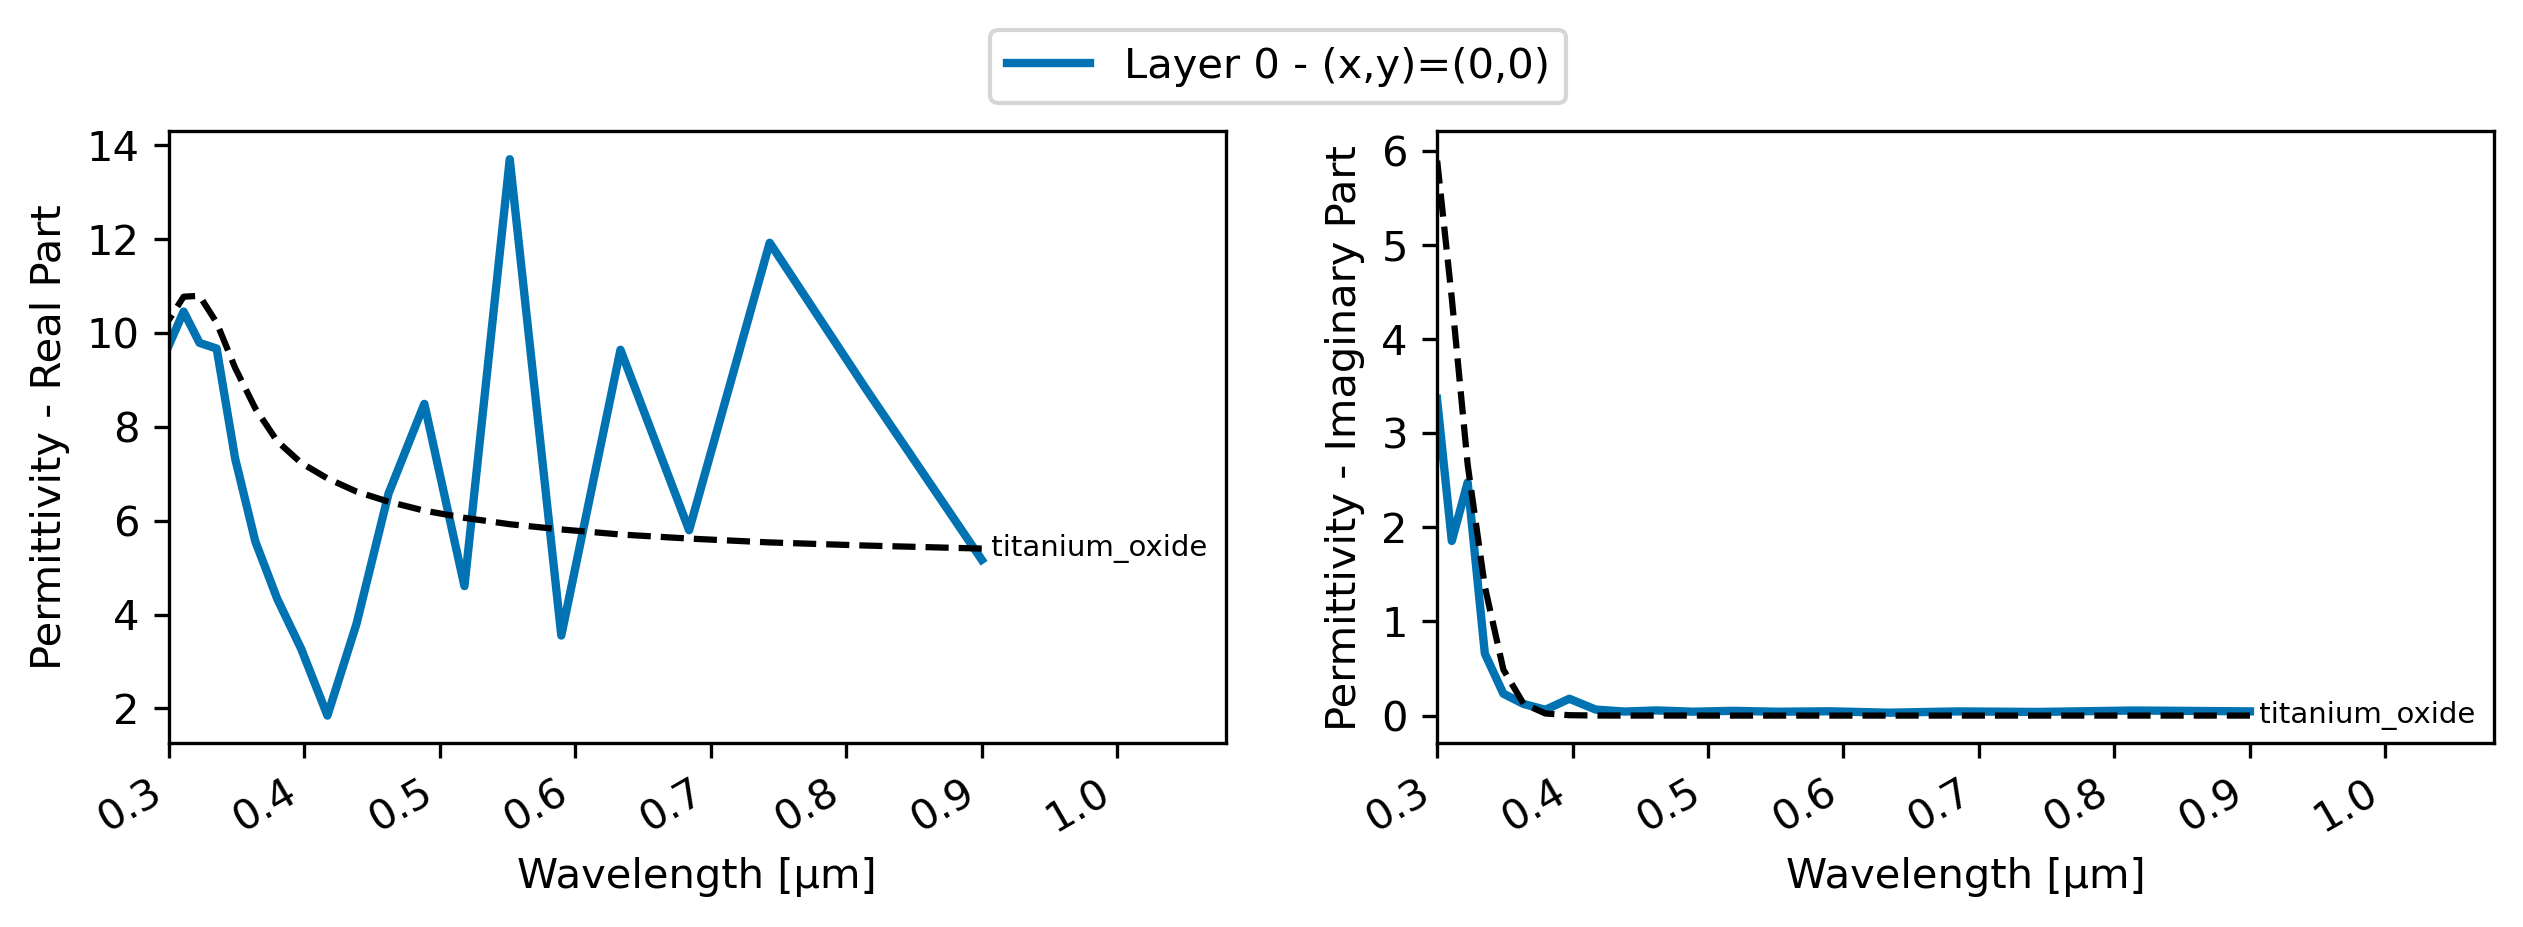

In [7]:
nidn.plot_eps_per_point(cfg,compare_to_material="titanium_oxide")

In [8]:
cfg.name = "1layer_fdtd_reg"
nidn.save_run(cfg)

23:32:02|NIDN-INFO| Saving run to file: ../results//1layer_fdtd_reg_26-05-2022 23-32-02_run.pk


# Single layer , uniform, classification

In [9]:
cfg.pop("model",None); # Forget the old model

# Allowed range of epsilon values
cfg.real_min_eps = 0.0
cfg.real_max_eps = 20.0
cfg.imag_min_eps = 0.0
cfg.imag_max_eps = 6.0

cfg.type = "classification" # Choose type as described above
cfg.iterations = 150 # Set number of training iterations (that is forward model evaluations) to perform

In [10]:
nidn.run_training(cfg);

23:32:02|NIDN-WARNING| Due to the grid resolution, the thickness of layer 1 is set to 0.390 µminstead of the specified 0.38 µm
23:33:19|NIDN-INFO| ###  New Best=0.2845 with SpectrumLoss=0.2795 ### L1=0.2795
23:33:19|NIDN-INFO| It=0     Loss=0.2845   |  weighted_avg=0.2845  |  SpectrumLoss=0.2795 | L1=0.2795
23:35:08|NIDN-INFO| ###  New Best=0.2649 with SpectrumLoss=0.2608 ### L1=0.2608
23:36:59|NIDN-INFO| ###  New Best=0.2047 with SpectrumLoss=0.2020 ### L1=0.2020
23:38:46|NIDN-INFO| ###  New Best=0.1573 with SpectrumLoss=0.1546 ### L1=0.1546
23:40:37|NIDN-INFO| ###  New Best=0.1265 with SpectrumLoss=0.1223 ### L1=0.1223
23:42:28|NIDN-INFO| ###  New Best=0.1043 with SpectrumLoss=0.1005 ### L1=0.1005
23:42:28|NIDN-INFO| It=5     Loss=0.1043   |  weighted_avg=0.1904  |  SpectrumLoss=0.1005 | L1=0.1005
23:44:15|NIDN-INFO| ###  New Best=0.0992 with SpectrumLoss=0.0955 ### L1=0.0955
23:48:40|NIDN-INFO| ###  New Best=0.0892 with SpectrumLoss=0.0852 ### L1=0.0852
23:50:47|NIDN-INFO| ###  New 

01:46:50|NIDN-INFO| ###  New Best=0.0320 with SpectrumLoss=0.0317 ### L1=0.0317
01:49:21|NIDN-INFO| ###  New Best=0.0320 with SpectrumLoss=0.0316 ### L1=0.0316
01:56:33|NIDN-INFO| It=70    Loss=0.0320   |  weighted_avg=0.0322  |  SpectrumLoss=0.0316 | L1=0.0316
01:58:19|NIDN-INFO| ###  New Best=0.0320 with SpectrumLoss=0.0316 ### L1=0.0316
02:00:27|NIDN-INFO| ###  New Best=0.0319 with SpectrumLoss=0.0316 ### L1=0.0316
02:05:17|NIDN-INFO| ###  New Best=0.0319 with SpectrumLoss=0.0316 ### L1=0.0316
02:07:20|NIDN-INFO| ###  New Best=0.0319 with SpectrumLoss=0.0316 ### L1=0.0316
02:07:20|NIDN-INFO| It=75    Loss=0.0319   |  weighted_avg=0.0321  |  SpectrumLoss=0.0316 | L1=0.0316
02:09:47|NIDN-INFO| ###  New Best=0.0319 with SpectrumLoss=0.0315 ### L1=0.0315
02:18:10|NIDN-INFO| ###  New Best=0.0319 with SpectrumLoss=0.0315 ### L1=0.0315
02:18:10|NIDN-INFO| It=80    Loss=0.0319   |  weighted_avg=0.0320  |  SpectrumLoss=0.0315 | L1=0.0315
02:22:15|NIDN-INFO| ###  New Best=0.0319 with Spectrum

04:45:05|NIDN-WARNING| Due to the grid resolution, the thickness of layer 1 is set to 0.390 µminstead of the specified 0.38 µm


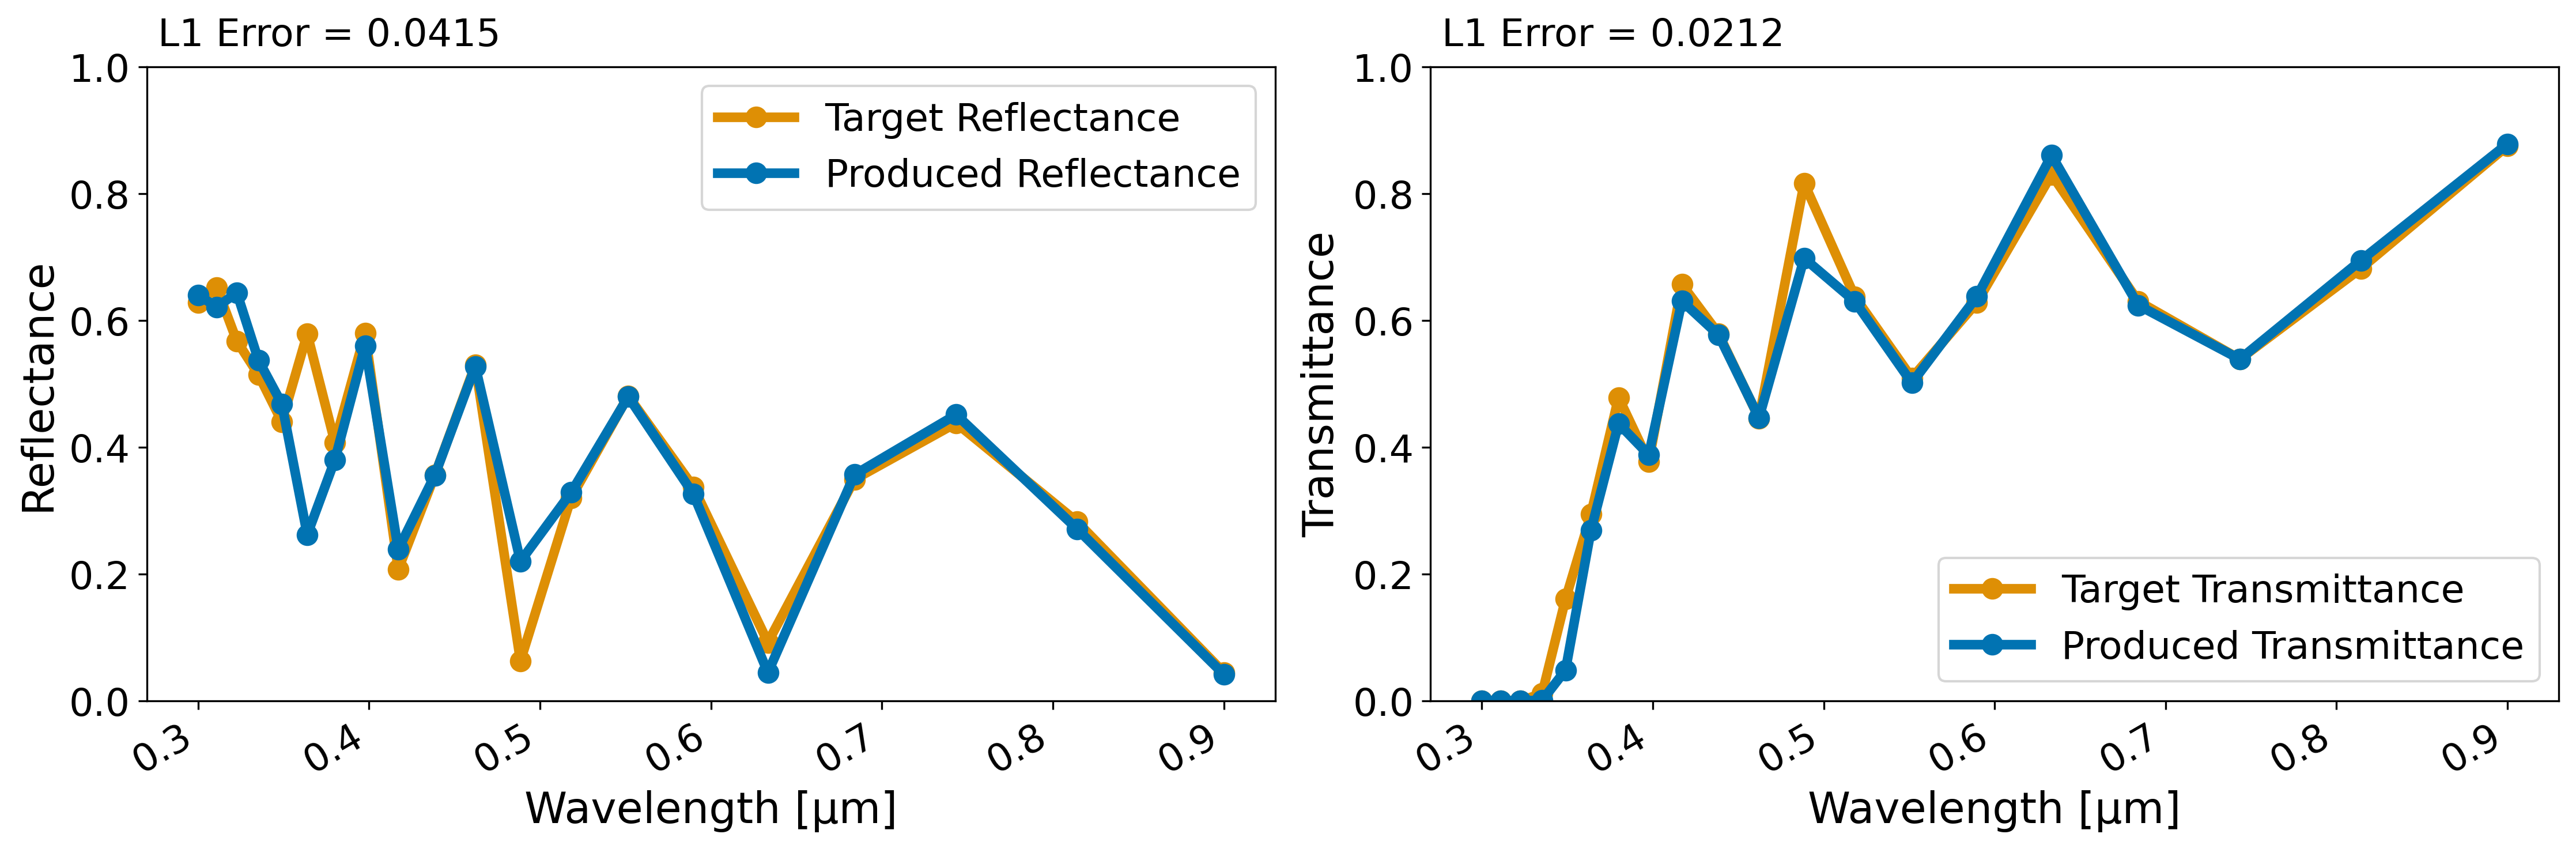

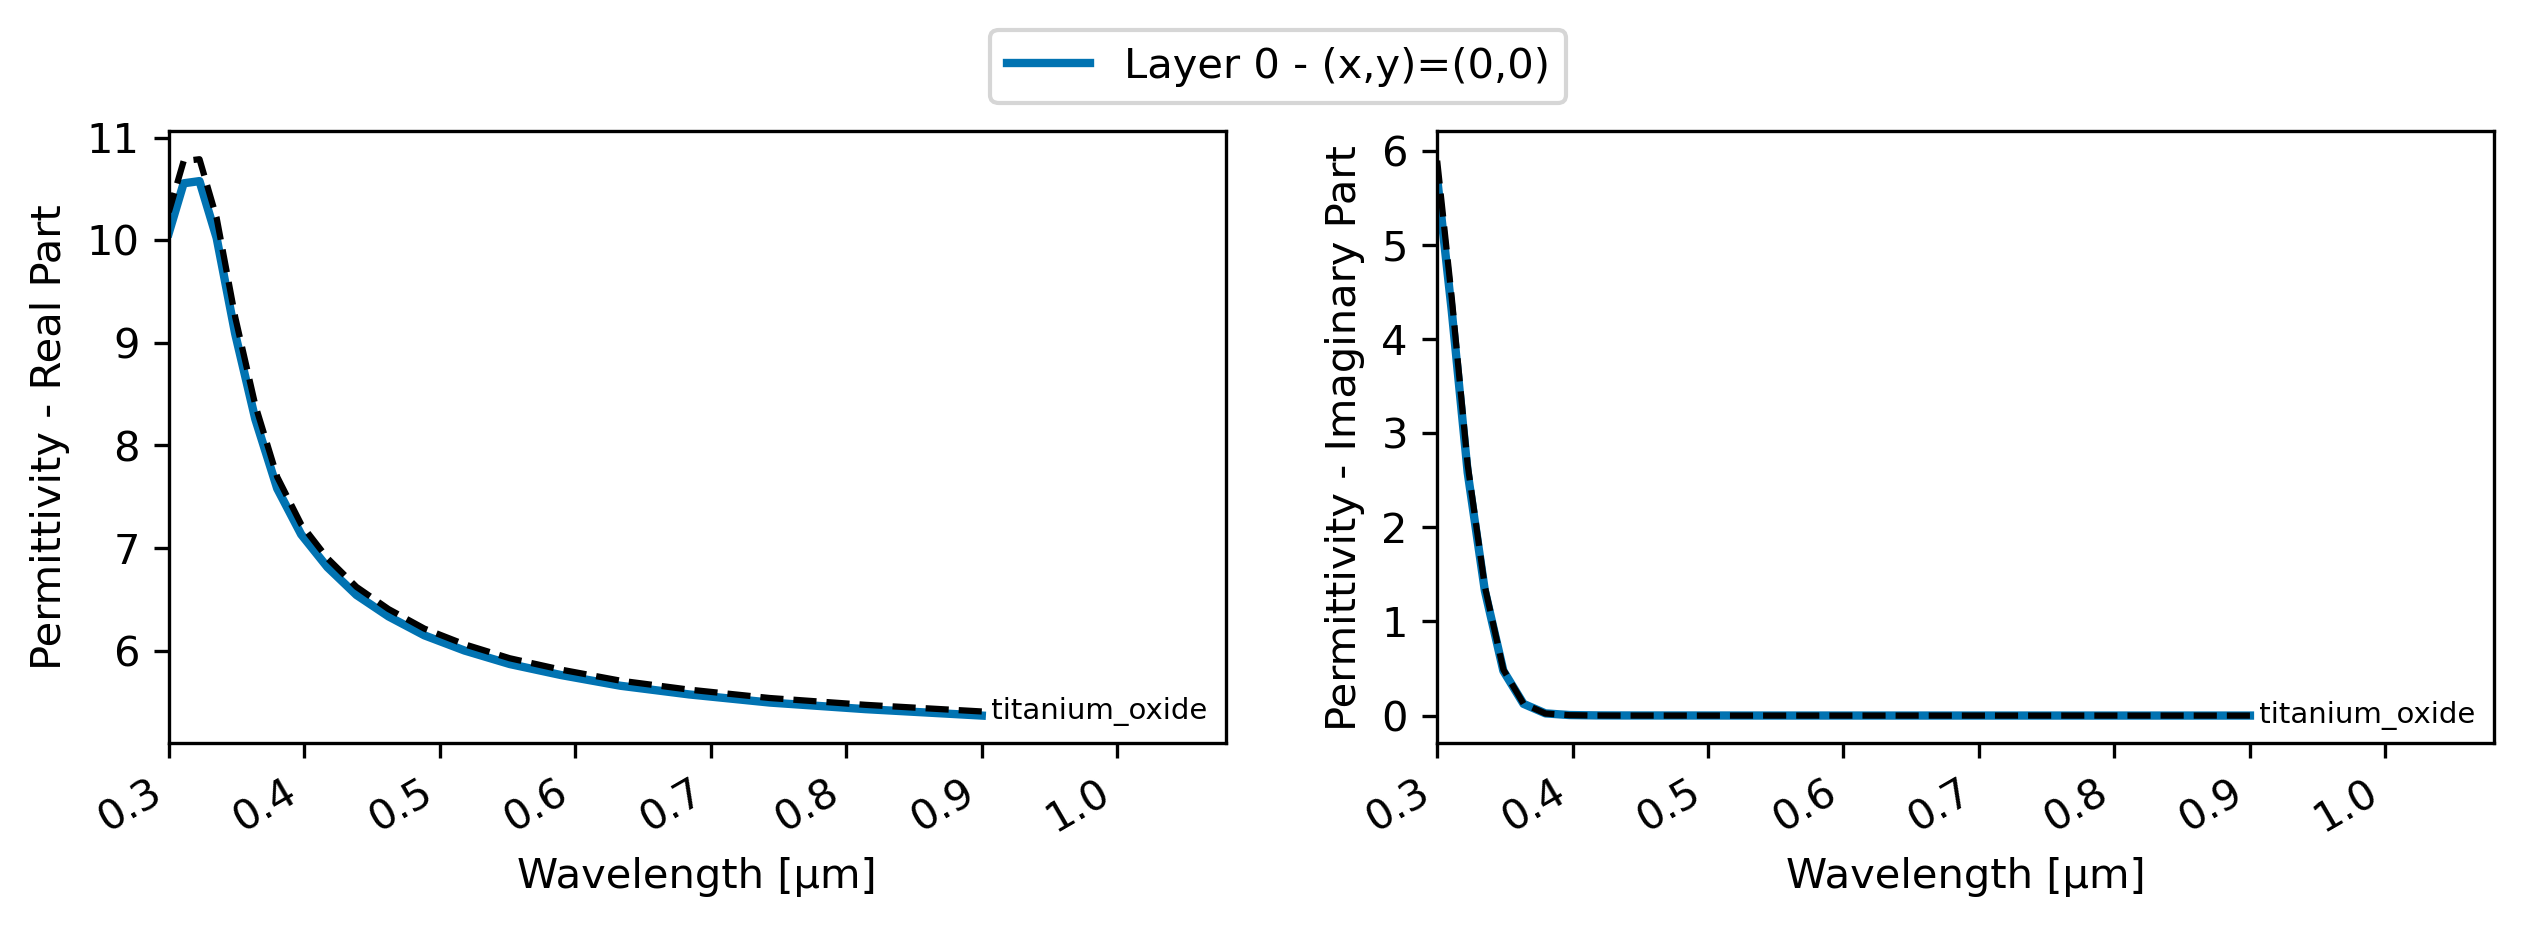

In [11]:
nidn.plot_spectra(cfg)
nidn.plot_eps_per_point(cfg)

In [12]:
cfg.name = "1layer_fdtd_class"
nidn.save_run(cfg)

04:48:15|NIDN-INFO| Saving run to file: ../results//1layer_fdtd_class_27-05-2022 04-48-15_run.pk


## Uniform Three-Layer Ground Truth 

In [ ]:
# Load default cfg as starting point
cfg = nidn.load_default_cfg()

# Set grid specifics
cfg.Nx = 1
cfg.Ny = 1
cfg.N_layers = 3
cfg.N_freq = 16
cfg.PER_LAYER_THICKNESS = [0.1]
cfg.FDTD_pulse_type = 'continuous'
cfg.FDTD_source_type = 'line'

# Specify your desired range of wavelengths
cfg.physical_wavelength_range[0] = 8e-7 
cfg.physical_wavelength_range[1] = 1.5e-6

cfg.target_reflectance_spectrum = [0.41897427,0.39591158,0.41332836,0.44050670,0.47452302,0.50973356,0.52690292,0.53404939,0.51684631,0.40007779,0.40960854,0.54935004,0.50675232,0.67787965,0.66292254,0.79244483,]
cfg.target_transmittance_spectrum = [0.57266058,0.59123892,0.57286972,0.54174457,0.50317150,0.46341936,0.42688453,0.38601254,0.30563326,0.26237625,0.15404439,0.08091528,0.06232964,0.03206342,0.02864806,0.01709644,]

cfg.FDTD_niter = 500
cfg.solver ="FDTD"

nidn.plot_spectrum(cfg,
                   cfg.target_reflectance_spectrum,
                   cfg.target_transmittance_spectrum)

In [ ]:
# Allowed range of epsilon values
cfg.pop("model",None); # Forget the old model
cfg.real_min_eps = 0.1
cfg.real_max_eps = 20.0
cfg.imag_min_eps = 0.0
cfg.imag_max_eps = 20.0

cfg.type = "regression" # Choose type as described above (for now still regression)
cfg.iterations = 100 # Set number of training iterations (that is forward model evaluations) to perform

In [ ]:
nidn.run_training(cfg);

In [ ]:
nidn.plot_eps_per_point(cfg,compare_to_material=["titanium_oxide","germanium","tantalum_pentoxide"])

In [ ]:
# The other plots
nidn.plot_spectra(cfg)

In [ ]:
cfg.name = "3layer_fdtd_reg"
nidn.save_run(cfg)

In [ ]:
# Allowed range of epsilon values
cfg.pop("model",None); # Forget the old model

cfg.type = "classification" # Choose type as described above (for now still regression)
cfg.iterations = 100 # Set number of training iterations (that is forward model evaluations) to perform

In [ ]:
nidn.run_training(cfg);

In [ ]:
nidn.plot_eps_per_point(cfg,compare_to_material=["titanium_oxide","germanium","tantalum_pentoxide"])

In [ ]:
nidn.plot_spectra(cfg)

In [ ]:
cfg.name = "3layer_fdtd_class"
nidn.save_run(cfg)